# CS 584 Assignment 4 -- Sequence to Sequence Models

#### Name: Archana Kalburgi
#### Stevens ID: 10469491

## In this assignment, you are required to follow the steps below:
1. Review the lecture slides.
2. Implement the seq2seq (translation) model.

**Before you start**
- Please read the code very carefully.
- Install these packages using the following command.
```console
pip install -r requirements.txt
```
- It's better to train the Tensorflow model with GPU and CUDA. If they are not available on your local machine, please consider Google CoLab. You can check `CoLab.md` in this assignments.
- You are **NOT** allowed to use other packages unless otherwise specified.
- You are **ONLY** allowed to edit the code between `# Start your code here` and `# End` for each block.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import os


def print_line(*args):
    """ Inline print and go to the begining of line
    """
    args1 = [str(arg) for arg in args]
    str_ = ' '.join(args1)
    print('\r' + str_, end='')

In [3]:
! pip install -r "/content/drive/MyDrive/nlp_assignments/Assignment4_kalburgi_Archana/requirements.txt"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import tensorflow as tf


# If you are going to use GPU, make sure the GPU in in the output
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
from typing import List, Tuple, Union, Dict

import numpy as np

## 1. Data preparation (5 Points)

### 1.1 Load and describe data

Here, we use the [iwslt2017](https://huggingface.co/datasets/iwslt2017) dataset. More specifically, this translation task is from French to English: fr-en.

In [6]:
from datasets import load_dataset
# The load_dataset function is provided by the huggingface datasets
# https://huggingface.co/docs/datasets/index


dataset_path = os.path.join('a4-data', 'dataset')
dataset = load_dataset('iwslt2017', 'iwslt2017-en-fr', cache_dir=dataset_path, ignore_verifications=True)

  0%|          | 0/3 [00:00<?, ?it/s]

Let's first print some basic statistics of this dataset

In [7]:
print(dataset)
print(len(dataset['train']['translation']), len(dataset['validation']['translation']), len(dataset['test']['translation']))

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 232825
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 8597
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 890
    })
})
232825 890 8597


In [8]:
dataset['train']['translation'][:5]

[{'en': "Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.",
  'fr': "Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant."},
 {'en': 'I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.',
  'fr': "J'ai été très impressionné par cette conférence, et je tiens à vous remercier tous pour vos nombreux et sympathiques commentaires sur ce que j'ai dit l'autre soir."},
 {'en': 'And I say that sincerely, partly because  Put yourselves in my position.',
  'fr': "Et je dis çà sincèrement, en autres parce que --Faux sanglot-- j'en ai besoin ! --Rires-- Mettez-vous à ma place!"},
 {'en': 'I flew on Air Force Two for eight years.',
  'fr': "J'ai volé avec Air Force 2 pendant huit ans."},
 {'en': 'Now I have to take off my shoes or boots to get on an airpl

In [9]:
from tokenizers import Tokenizer
# The tokenizer is provided by the huggingface tokenizers
# https://huggingface.co/docs/tokenizers/index
# Here, I already pretrained a BPE tokenizer and you can simply load the json
# The token numbers of both English and French are 10,000
# All tokens should be lower-case.


en_tokenizer = Tokenizer.from_file('/content/drive/MyDrive/nlp_assignments/Assignment4_kalburgi_Archana/a4-data/en_tokenizer.json')
fr_tokenizer = Tokenizer.from_file('/content/drive/MyDrive/nlp_assignments/Assignment4_kalburgi_Archana/a4-data/fr_tokenizer.json')

In [10]:
encoding = en_tokenizer.encode("i like sports.")
print(encoding.ids)
print(encoding.tokens)
# >>> [0, 122, 279, 4987, 17, 1] 
# >>> ['<s>', 'Ġi', 'Ġlike', 'Ġsports', '.', '</s>']

[0, 122, 279, 4987, 17, 1]
['<s>', 'Ġi', 'Ġlike', 'Ġsports', '.', '</s>']


Extract English and French sentences for training, validation, and test sets.

Note: Every sentence is lower-case.

In [11]:
train_en_sentences, train_fr_sentences = zip(*[(pair['en'].lower(), pair['fr'].lower()) for pair in dataset['train']['translation']])
valid_en_sentences, valid_fr_sentences = zip(*[(pair['en'].lower(), pair['fr'].lower()) for pair in dataset['validation']['translation']])
test_en_sentences, test_fr_sentences = zip(*[(pair['en'].lower(), pair['fr'].lower()) for pair in dataset['test']['translation']])

### 1.2 Encode data (5 Points)

In [12]:
def encode(tokenizer: 'Tokenizer', sentences: List[str]) -> List[List[int]]:
    """ Encode the sentences with the pretrained tokenizer.
        You can directly call `tokenizer.encode()` to encode the sentences.
        It will automatically add the <s> and </s> token.
        
        Note: Please be carefull with the return value of the encode function.
    
    Args:
        tokenizer: A pretrained en/fr tokenizer
        sentences: A list of strings
    Return:
        sent_token_ids: A list of token ids
    """
    sent_token_ids = []
    n = len(sentences)
    for i, sentence in enumerate(sentences):
        if i % 100 == 0 or i == n - 1:
            print_line('Encoding with Tokenizer:', (i + 1), '/', n)
        # Start your code here
        sentence_id = tokenizer.encode(sentence).ids
        sent_token_ids.append(sentence_id)
        # End
    print_line('\n')
    return sent_token_ids


In [13]:
print('en')
train_en = encode(en_tokenizer, train_en_sentences)
valid_en = encode(en_tokenizer, valid_en_sentences)
test_en = encode(en_tokenizer, test_en_sentences)
print('fr')
train_fr = encode(fr_tokenizer, train_fr_sentences)
valid_fr = encode(fr_tokenizer, valid_fr_sentences)
test_fr = encode(fr_tokenizer, test_fr_sentences)

en
Encoding with Tokenizer: 232825 / 232825
Encoding with Tokenizer: 890 / 890
Encoding with Tokenizer: 8597 / 8597
fr
Encoding with Tokenizer: 232825 / 232825
Encoding with Tokenizer: 890 / 890
Encoding with Tokenizer: 8597 / 8597


Check your implementation with an example

In [14]:
print(dataset['train']['translation'][0])
print(train_en[0], train_fr[0])
print(en_tokenizer.decode(train_en[0]), fr_tokenizer.decode(train_fr[0]))

{'en': "Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.", 'fr': "Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant."}
[0, 658, 162, 188, 494, 15, 2843, 17, 138, 165, 178, 2775, 121, 630, 4502, 140, 222, 124, 1930, 140, 625, 140, 185, 2122, 3446, 30, 122, 400, 2576, 5818, 17, 1] [0, 763, 478, 15, 3016, 17, 145, 10, 178, 487, 169, 8981, 152, 1038, 2055, 266, 323, 2425, 220, 1760, 586, 17, 214, 459, 378, 9952, 17, 1]
 thank you so much, chris. and it's truly a great honor to have the opportunity to come to this stage twice; i'm extremely grateful.  merci beaucoup, chris. c'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. je suis très reconnaissant.


## 2. Sequence to sequence model (40 Points)

### 2.1 Encoder (10 Points)

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, GRU, Dense, Embedding, Dropout
from tensorflow.keras.initializers import GlorotUniform


class Encoder(Model):
    def __init__(self, vocab_size: int, embedding_size: int, units: int):
        """ The encoder model for the src sentences.
            It contains an embedding part and a GRU part.
        
        Args:
            vocab_size: The src vocabulary size
            embedding_size: The embedding size for the embedding layer
            units: Number of hidden units in the RNN (GRU) layer
        """
        super().__init__()
        # Start your code here
        # Note: Please know what the decoder needs from encoder. This determines the parameters of the GRU layer
        self.embedding = Embedding(vocab_size, embedding_size) # embedding part 
        self.gru = GRU(units, return_sequences=True, return_state = True) # gru part 
        # End

    def call(self, src_ids, src_mask):
        """ Encoder forward
        Args:
            src_ids: Tensor, (batch_size x max_len), the token ids of input sentences in a batch
            src_mask: Tensor, (batch_size x max_len), the mask of the src input. True value in the mask means this timestep is valid, otherwise this timestep is ignored
        Returns:
            enc_output: Tensor, (batch_size x max_len x units), the output of GRU for all timesteps
            final_state: Tensor, (batch_size x units), the state of the final valid timestep
        """
        # Start your code here
        # Step 1. Retrieve embedding
        #      2. GRU
        # Please refer to the calling arguments of GRU: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU#call-arguments
        self.src_ids_embeddings = self.embedding(src_ids)
        enc_outputs, final_state = self.gru(inputs = self.src_ids_embeddings, mask=src_mask)
        # End
        return enc_outputs, final_state
    

### 2.2 Decoder (15 Points)

In [16]:
class Decoder(Model):
    def __init__(self, vocab_size: int, embedding_size: int, units: int, dropout_rate: float):
        """ The decoder model for the tgt sentences.
            It contains an embedding part, a GRU part, a dropout part, and a classifier part.
            
        Args:
            vocab_size: The tgt vocabulary size
            embedding_size: The embedding size for the embedding layer
            units: Number of hidden units in the RNN (GRU) layer
            dropout_rate: The classifier has a (units x vocab_size) weight. This is a large weight matrix. We apply a dropout layer to avoid overfitting.
        """
        super().__init__()
        # Start your code here
        # Note: 1. Please correctly set the parameter of GRU
        #       2. No softmax here because we will need the sequence to sequence loss later
        
        self.embedding = Embedding(vocab_size, embedding_size)
        self.dropout = Dropout(dropout_rate)
        self.gru = GRU(units, return_sequences = True)
        self.classifier = Dense(units = vocab_size)
    
        # End

    def call(self, tgt_ids, initial_state, tgt_mask):
        """ Decoder forward.
            It is called by decoder(tgt_ids=..., initial_state=..., tgt_mask=...)

        Args:
            tgt_ids: Tensor, (batch_size x max_len), the token ids of input sentences in a batch
            initial_state: Tensor, (batch_size x units), the state of the final valid timestep from the encoder
            tgt_mask: Tensor, (batch_size x max_len), the mask of the tgt input. True value in the mask means this timestep is valid, otherwise this timestep is ignored
        Return:
            dec_outputs: Tensor, (batch_size x max_len x vocab_size), the output of GRU for all timesteps
        """
        # Start your code here
        # Step 1. Retrieve embedding
        #      2. GRU
        #      3. Apply dropout to the GRU output
        #      4. Classifier
        # Note: Please refer to the calling arguments of GRU: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU#call-arguments
        embedded_target_ids = self.embedding(tgt_ids)
        dec_outputs = self.gru(inputs = embedded_target_ids, mask=tgt_mask, initial_state = initial_state)
        dec_outputs = self.dropout(dec_outputs)
        dec_outputs = self.classifier(dec_outputs)
        # End
        return dec_outputs
    
    def predict(self, tgt_ids, initial_state):
        """ Decoder prediction.
            This is a step in recursive prediction. We use the previous prediction and state to predict current token.
            Note that we only need to use the gru_cell instead of GRU becasue we only need to calculate one timestep.
            
        Args:
            tgt_ids: Tensor, (batch_size, ) -> (1, ), the token id of the current timestep in the current sentence.
            initial_state: Tensor, (batch_size x units) -> (1 x units), the state of the final valid timestep from the encoder or the previous hidden state in prediction.
        Return:
            dec_outputs: Tensor, (batch_size x vocab_size) -> (1 x vocab_size), the output of GRU for this timestep.
            state: Tensor, (batch_size x units) -> (1 x units), the state of this timestep.
        """
        gru_cell = self.gru.cell
        # Start your code here
        # Step 1. Retrieve embedding
        #      2. GRU Cell, see https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRUCell#call-arguments
        #      3. Classifier (No dropout)
        embedded_target_ids = self.embedding(tgt_ids)
        dec_outputs, state = gru_cell(inputs = embedded_target_ids, states = initial_state, training = False)
        dec_outputs = self.classifier(dec_outputs)
        # End
        return dec_outputs, state
    

### 2.3 Seq2seq (10 Points)

In [17]:
class Seq2seq(Model):
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int, embedding_size: int, units: int, dropout_rate: float):
        """ The sequence to sequence model.
            It contains an encoder and a decoder.
            
        Args:
            src_vocab_size: The src vocabulary size
            tgt_vocab_size: The tgt vocabulary size
            embedding_size: The embedding size for the embedding layer
            units: Number of hidden units in the RNN (GRU) layer
            dropout_rate: The dropout rate used in the decoder.
        """
        super().__init__()
        # Start your code here
        self.encoder = Encoder(vocab_size = src_vocab_size, embedding_size = embedding_size, units = units)
        self.decoder = Decoder(vocab_size = tgt_vocab_size, embedding_size = embedding_size, units = units, dropout_rate = dropout_rate)
        # End

    def call(self, src_ids, src_seq_lens, tgt_ids, tgt_seq_lens):
        """ Seq2seq forward (for the loss calculation in training/validation only).
            It is called by model(src_ids=..., src_seq_lens=..., tgt_ids=..., tgt_seq_lens=)
            Note: In prediction, we will also need to set `training=False`.

        Args:
            src_ids: Tensor, (batch_size x max_len), the token ids of src sentences in a batch
            src_seq_lens: Tensor, (batch_size, ), the length of src sentences in a batch
            tgt_ids: Tensor, (batch_size x max_len), the token ids of tgt sentences in a batch
            tgt_seq_lens: Tensor, (batch_size, ), the length of src sentences in a batch
        Returns:
            dec_outputs: Tensor, (batch_size x max_len x units), the decoder predictions
        """
        # Start your code here
        # Step 1. build mask for src and tgt
        #      2. encoder forward
        #      3. decoder forward
        pad_token = fr_tokenizer.token_to_id('<pad>')
        src_mask = src_ids != pad_token
        tgt_mask = tgt_ids != pad_token
        enc_outputs, enc_state = self.encoder(src_ids, src_mask)
        dec_outputs = self.decoder(tgt_ids, enc_state, tgt_mask)
        # End
        return dec_outputs

### 2.4 Seq2seq loss (5 Points)

In [18]:
from tensorflow_addons.seq2seq import sequence_loss


def seq2seq_loss(logits, target, seq_lens):
    """ Calculate the sequence to sequence loss using the sequence_loss from tensorflow
    
    Args:
        logits: Tensor (batch_size x max_seq_len x vocab_size). The output of the RNN model.
        target: Tensor (batch_size x max_seq_len). The groud-truth of words.
        seq_lens: Tensor (batch_size, ). The real sequence length before padding.
    """
    loss = 0
    # Start your code here
    # 1. make a sequence mask (batch_size x max_seq_len) using tf.sequence_mask. This is to build a mask with 1 and 0.
    #    Entry with 1 is the valid time step without padding. Entry with 0 is the time step with padding. We need to exclude this time step.
    # 2. calculate the loss with sequence_loss. Carefully read the documentation of each parameter
    seq_mask = tf.sequence_mask(seq_lens, dtype = tf.dtypes.float32)
    loss = sequence_loss(logits, target, seq_mask, sum_over_timesteps=False, sum_over_batch=False, average_across_batch=True, average_across_timesteps=True)
    # End
    return loss

## 3. Training (50 Points)

### 3.1 Pad batch (15 Points)

`pad_src_batch`: 5 Points
`pad_tgt_batch`: 10 Points

Pad the batch to the equal length and make tensors.

In [19]:
# padded_src = [i + [pad_val]*(max_len - len(i)) for i in src_batch]

In [20]:
def helper_function(batch, pad_val, max_length):
  result = []
  for i in batch:
    result.append(i + [pad_val]*(max_length - len(i)))
  return result 

In [21]:
def pad_src_batch(src_batch: List[List[int]], src_seq_lens: List[int], pad_val: int):
    """ Pad the batch for src sentences.
        Note: Do not use append/extend that can modify the input inplace.
    
    Args:
        src_batch: A list of src token ids
        src_seq_lens: A list of src lens
        pad_val: The padding value
        
    Returns:
        src_batch: Tensor, (batch_size x max_len)
        src_seq_lens_batch: Tensor, (batch_size, )
    """
    max_src_len = max(src_seq_lens)
    # Start your code here
    # Please refer to tf.convert_to_tensor. The dtype should be tf.int64
    # Padding
    max_len = max(src_seq_lens)
    padded_src = helper_function(src_batch, pad_val, max_len)
    # Convert to tensor
    src_batch = tf.convert_to_tensor(padded_src, dtype=tf.int64)
    src_seq_lens_batch = tf.convert_to_tensor(src_seq_lens, dtype=tf.int64)
    # End
    return src_batch, src_seq_lens_batch

In [22]:
def pad_tgt_batch(tgt_batch: List[List[int]], tgt_seq_lens: List[int], pad_val: int):
    """ Pad the batch for tgt sentences.
        Note: 1. Do not use append/extend that can modify the input inplace.
              2. We need to build the x (feature) and y (label) for tgt sentences.
                 Please understand what the feature and label are in translation.
    
    Args:
        tgt_batch: A list of src token ids
        tgt_seq_lens: A list of src lens
        pad_val: The padding value
        
    Returns:
        tgt_x_batch: Tensor, (batch_size x max_len)
        tgt_y_batch: Tensor, (batch_size x max_len)
        src_seq_lens_batch: Tensor, (batch_size, )
    """
    tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch = [], [], []
    for sent, seq_len in zip(tgt_batch, tgt_seq_lens):
        # Start your code here
        # Append x, y, and seq_len
        tgt_x_batch.append(sent[:-1])
        tgt_y_batch.append(sent[1:])
        tgt_seq_lens_batch.append(seq_len-1)
        # End

    max_tgt_len = max(tgt_seq_lens_batch)
    # Start your code here
    # Please refer to tf.convert_to_tensor. The dtype should be tf.int64
    # Padding
    padded_tgt_x = helper_function(tgt_x_batch, pad_val, max_tgt_len) 
    padded_tgt_y = helper_function(tgt_y_batch, pad_val, max_tgt_len) 
    # Convert to tensor
    tgt_x_batch = tf.convert_to_tensor(padded_tgt_x, dtype=tf.int64)
    tgt_y_batch = tf.convert_to_tensor(padded_tgt_y, dtype=tf.int64)
    tgt_seq_lens_batch = tf.convert_to_tensor(tgt_seq_lens_batch, dtype=tf.int64)
    # End
    return tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch

In [23]:
def pad_batch(src_batch: List[List[int]], src_seq_lens: List[int], tgt_batch: List[List[int]], tgt_seq_lens: List[int], pad_val: int):
    src_batch, src_seq_lens_batch = pad_src_batch(src_batch, src_seq_lens, pad_val)
    tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch = pad_tgt_batch(tgt_batch, tgt_seq_lens, pad_val)
    return src_batch, src_seq_lens_batch, tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch

### 3.2 Batch Index Sampler (10 Points)

Create a index sampler to sample data index for each batch.

This is to make the sentences in each batch have similar lengths to speed up training.

Example:
```
Assume the sentence lengths are: [5, 2, 3, 6, 2, 3, 6] and batch_size is 2.
We can make the indices in the batches as follows:
[1, 4] of length 2
[2, 5] of length 3
[0, 3] of lengths 5 and 6
[6] of length 6
```

In [24]:
class SeqLenBatchSampler:
    def __init__(self, seq_lens: List[int], batch_size: int, seed: int = 6666):
        """ The index sampler.
            It can be used with iteration:
            ```
            n_batch = len(sampler)
            for indices in sampler:
                ...
            ```
            
            Args:
                seq_lens: A list training sequence lengths (src)
                batch_size: .
                seed: .
        """
        np.random.seed(seed)
        self.seq_lens = seq_lens
        self.batch_size = batch_size
        self.batches = self._make_batch_index()

        self.n_batch = len(self.batches)
        self.counter = -1
        
    def _make_batch_index(self) -> List[List[int]]:
        """ Build the indexes in each batch.

            Return:
                batches: A list of indices batch, e.g., [[0, 2, 8], [3, 6, 4], [5, 1, 7], ...]
        """
        n = len(self.seq_lens)
        n_batch = int(np.ceil(n / self.batch_size))
        batches = []
        # Start your code here
        # Step 1. Use np.argsort to get all indices with sorted length
        #      2. Split the indices into batches using a for loop: `for i in range(n_batch):`
        sorted_seq_lens = np.argsort(self.seq_lens)
        for i in range(n_batch):
            start = i*self.batch_size
            end = start + self.batch_size
            batches.append(sorted_seq_lens[start:end])
        # End
        return batches
    
    def __len__(self):
        return self.n_batch
    
    def __item__(self, index):
        return self.batches[index]
    
    def __iter__(self):
        np.random.shuffle(self.batches)
        self.counter = -1
        return self

    def __next__(self):
        self.counter += 1
        if self.counter < self.n_batch:
            return self.batches[self.counter]
        raise StopIteration

### 3.3 Running the model

Generate the length

In [25]:
np.random.seed(6666)
train_seq_lens_en = [len(en_sent) for en_sent in train_en]
train_seq_lens_fr = [len(fr_sent) for fr_sent in train_fr]
valid_seq_lens_en = [len(en_sent) for en_sent in valid_en]
valid_seq_lens_fr = [len(fr_sent) for fr_sent in valid_fr]
test_seq_lens_en = [len(en_sent) for en_sent in test_en]
test_seq_lens_fr = [len(fr_sent) for fr_sent in test_fr]

Create np array

In [26]:
train_en = np.array(train_en, dtype=object)
train_seq_lens_en = np.array(train_seq_lens_en)
train_fr = np.array(train_fr, dtype=object)
train_seq_lens_fr = np.array(train_seq_lens_fr)

Model parameters

In [27]:
import random


seed = 6666
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [28]:
src_vocab_size = len(fr_tokenizer.get_vocab())
tgt_vocab_size = len(en_tokenizer.get_vocab())
hidden_units = 256
embedding_dim = 128
dropout_rate = 0.0

In [29]:
model = Seq2seq(src_vocab_size, tgt_vocab_size, embedding_dim, hidden_units, dropout_rate)

In [30]:
num_epoch = 15
batch_size = 256
learning_rate = 1e-3

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_batch_sampler = SeqLenBatchSampler(train_seq_lens_fr, batch_size)

In [32]:
n_training_samples = len(train_fr)
n_valid_batch = int(np.ceil(len(valid_fr) / batch_size))
pad_token_id = fr_tokenizer.token_to_id('<pad>')
train_losses, valid_losses = [], []
for epoch in range(num_epoch):
    epoch_loss = 0.0
    for batch_idx, data_index in enumerate(train_batch_sampler):
        src_batch, src_seq_lens = train_fr[data_index], train_seq_lens_fr[data_index]
        tgt_batch, tgt_seq_lens = train_en[data_index], train_seq_lens_en[data_index]
        real_batch_size = len(src_batch)
        (src_batch, src_seq_lens_batch,
         tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch) = pad_batch(src_batch, src_seq_lens,
                                                                   tgt_batch, tgt_seq_lens,
                                                                   pad_val=pad_token_id)

        with tf.GradientTape() as tape:
            output = model(src_batch, src_seq_lens_batch, tgt_x_batch, tgt_seq_lens_batch)
            loss = seq2seq_loss(output, tgt_y_batch, tgt_seq_lens_batch)

        print_line(f'Epoch {epoch + 1} / {num_epoch} - Step {batch_idx + 1} / {len(train_batch_sampler)} - loss: {loss:.4f}')

        trainable_vars = model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        optimizer.apply_gradients(zip(gradients, trainable_vars))
        epoch_loss += loss * real_batch_size

    valid_loss = 0.0
    for batch_idx in range(n_valid_batch):
        start = batch_idx * batch_size
        end = start + batch_size
        src_batch, src_seq_lens = valid_fr[start:end], valid_seq_lens_fr[start:end]
        tgt_batch, tgt_seq_lens = valid_en[start:end], valid_seq_lens_en[start:end]
        real_batch_size = len(src_batch)
        (src_batch, src_seq_lens_batch,
         tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch) = pad_batch(src_batch, src_seq_lens,
                                                                   tgt_batch, tgt_seq_lens,
                                                                   pad_val=pad_token_id)
        output = model(src_batch, src_seq_lens_batch, tgt_x_batch, tgt_seq_lens_batch, training=False)
        loss = seq2seq_loss(output, tgt_y_batch, tgt_seq_lens_batch)

        if batch_idx % 1 == 0 or batch_idx == len(valid_en) - 1:
            print_line(f'Epoch {epoch + 1} / {num_epoch} - Step {batch_idx + 1} / {n_valid_batch} - loss: {loss:.4f}')

        valid_loss += loss * real_batch_size
    train_epoch_loss = epoch_loss / n_training_samples
    valid_epoch_loss = valid_loss / len(valid_en)
    train_losses.append(train_epoch_loss)
    valid_losses.append(valid_epoch_loss)
    print(f'\rEpoch {epoch + 1} / {num_epoch} - Step {len(train_batch_sampler)} / {len(train_batch_sampler)} - train loss: {train_epoch_loss:.4f} - valid loss: {valid_epoch_loss:.4f}')

Epoch 1 / 15 - Step 910 / 910 - train loss: 5.9493 - valid loss: 5.6790
Epoch 2 / 15 - Step 910 / 910 - train loss: 4.6868 - valid loss: 4.9340
Epoch 3 / 15 - Step 910 / 910 - train loss: 4.0916 - valid loss: 4.6413
Epoch 4 / 15 - Step 910 / 910 - train loss: 3.7614 - valid loss: 4.4748
Epoch 5 / 15 - Step 910 / 910 - train loss: 3.5280 - valid loss: 4.3534
Epoch 6 / 15 - Step 910 / 910 - train loss: 3.3459 - valid loss: 4.2683
Epoch 7 / 15 - Step 910 / 910 - train loss: 3.1990 - valid loss: 4.1899
Epoch 8 / 15 - Step 910 / 910 - train loss: 3.0759 - valid loss: 4.1546
Epoch 9 / 15 - Step 910 / 910 - train loss: 2.9731 - valid loss: 4.1087
Epoch 10 / 15 - Step 910 / 910 - train loss: 2.8839 - valid loss: 4.0884
Epoch 11 / 15 - Step 910 / 910 - train loss: 2.8090 - valid loss: 4.0944
Epoch 12 / 15 - Step 910 / 910 - train loss: 2.7395 - valid loss: 4.0519
Epoch 13 / 15 - Step 910 / 910 - train loss: 2.6783 - valid loss: 4.0426
Epoch 14 / 15 - Step 910 / 910 - train loss: 2.6254 - valid 

If you implement everything correctly, the valid loss will be around 4.

In [33]:
model.summary(expand_nested=True)

Model: "seq2seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  1576448   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| embedding (Embedding)     multiple                  1280000   |
|                                                               |
| gru (GRU)                 multiple                  296448    |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 decoder (Decoder)           multiple                  4146448   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| embedding_1 (Embedding)   multiple                  1280000   |
|                                                               |
| dropout (Dropout)         multiple                  0         |
|                                                               |
| gru_1 (GRU)               multiple                  29644

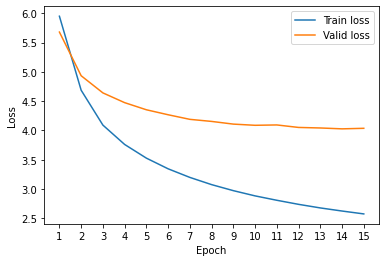

In [34]:
%matplotlib inline
from matplotlib import pyplot as plt


x = np.arange(1, len(train_losses) + 1)
plt.plot(x, train_losses, label='Train loss')
plt.plot(x, valid_losses, label='Valid loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(x)
plt.show()

### 3.4 Translate French to English (15 Points)

In [35]:
sos_token_id = en_tokenizer.token_to_id('<s>')
eos_token_id = en_tokenizer.token_to_id('</s>')
max_pred_len = 200
def translate(encoder: 'Encoder', decoder: 'Decoder', fr_sentences: List[List[int]]):
    """ Translate the src (French) sentences to English sentences.
        This is a recursive translation.
        
    Args:
        encoder: The encoder part in seq2seq
        decoder: The decoder part in seq2seq
        fr_sentences: The src token ids of all sentences
    Returns:
        pred_sentences: The predicted string sentences
    """
    n = len(fr_sentences)
    pred_sentences = []
    for i, src_ids in enumerate(fr_sentences):
        print_line(f'{i + 1} / {n}')
        # Shape of src_ids: (1 x seq_len)
        src_ids = tf.expand_dims(tf.convert_to_tensor(src_ids, dtype=tf.int64), axis=0)
        # pred is the prediction token ids. It starts with <s>
        pred = [sos_token_id]
        # Start your code here
        # Step 1. Calculate the encoder outputs and hidden states (similar to seq2seq2 model)
        # Step 2. Run a while loop when the last token in pred is not eos_token_id and the length of pred is less than max_pred_len
        # Step 3.     In the while loop, build the input (cur_token) of decoder: the last token of pred. Shape (batch_size, ) -> (1, )
        #             For example, if the current pred is [1, 50, 21, 8], the cur_token is [8]
        # Step 4.     In the while loop, use decoder.predict to get the decoder output
        # Step 5.     In the while loop, find the index with the maximum value. Then you can call tf.squeeze and numpy() to get the index
        # Step 6.     In the while loop, append the predicted token to pred
        # Step 7. Use en_tokenizer to decode the id to strings: pred_sentence
        src_mask = src_ids != pad_token_id
        encoder_output, final_state = encoder(src_ids, src_mask)
        while ( (pred[-1] != eos_token_id) and (len(pred)< max_pred_len) ):
          token = tf.reshape(tf.convert_to_tensor(pred[-1]),(1,))
          dec_output,final_state = decoder.predict(tgt_ids = token, initial_state = final_state)
          max_index = tf.math.argmax(dec_output[0]).numpy()
          pred.append(max_index)
        pred_sentence = en_tokenizer.decode(pred)
        # End
        pred_sentences.append(pred_sentence)
    print_line('\n')
    return pred_sentences

In [36]:
test_pred = translate(model.encoder, model.decoder, fr_sentences=test_fr)

8597 / 8597


### 3.5 Demonstrate 10 translation examples (5 Points)

In [37]:
np.random.seed(6666)
sample_num = 10
# Start your code here
# Use np.random.choice to sample 10 sentence indices. Remember to set correct replace
# Print format:
# 1.
# French: ...
# True English: ...
# Translated English: ...
# ------------------
sent_indices = np.random.choice(a=len(test_fr_sentences), size=sample_num, replace = False)
for i in range (len(sent_indices)):
  print(f"Fr: {test_fr_sentences [sent_indices[i]]}")
  print(f"En: {test_en_sentences [sent_indices[i]]}")
  print(f"Pred_en: {test_pred[sent_indices[i]]}")
  print("\n")
# End

Fr: les bonnes équipes envoient ces informations de façon à ce que les joueurs puissent s'en servir.
En: the good teams stream it in a way that the players can use.
Pred_en:  the good ones that have these programs are actually using the information that they can do.


Fr: merci.
En: thank you.
Pred_en:  thank you.


Fr: il y a eu plusieurs cas où c'était vraiment juste.
En: there have been several close calls.
Pred_en:  there were many cases where it was really.


Fr: mes prières vous accompagnent dans votre combat.
En: my prayers are with you for your fight.
Pred_en:  my prayer are going to be in my face in the fight.


Fr: et la question était : comment la technologie pourrait, les nouvelles technologies, y être ajoutée ?
En: and the question was: how could technology, new technology,  be added to that?
Pred_en:  and the question was, how could technology be new technologies, could we be able to do this?


Fr: combien d'entre vous ont vu l'ordinateur watson d'ibm gagner à jeopardy ?


### 3.6 Compute the bleu score (5 Points)

In [38]:
from IPython.core import prefilter
import evaluate


sacrebleu = evaluate.load('sacrebleu', cache_dir=dataset_path)
# Start your code here
# see https://huggingface.co/spaces/evaluate-metric/sacrebleu
# Note: please understand the format and meaning of references.

n = len(test_en_sentences)
references = list()
predictions = []
for i in range(n):
  references.append([test_en_sentences[i]])
  predictions.append(test_pred[i])
results = sacrebleu.compute(predictions=predictions, references=references)
# End
score = results['score']
print(round(score, 2))

6.67


If you implement everything correctly, the BLEU score will be around 7.

## Conclusion (5 Points)

Including but not limited to: translation example analysis (case study), bleu score analysis, model structure / parameter analysis, etc.

Answer:
- Through this assignment we got hands on experience of building Seq2Seq model to translated french sentences to english sentences and compared the translated ones with the original ones. 
- The model used to make these prediction has a total of 5,722,896 parameters all of with are trainiable 
- Encoder and the decoder were build using GRU layers. 
- We trained out own encoder and decoder for 15 epochs with a valid loss of around 4 and train loss of around 2
- The model is evaluated the Bleu score which is an evaluation metric for  evaluating machine-translated text. It measures the similarity of the machine-translated text to a set of reference translations. In this case we get a score of 7
- The model performace fairly well in some case like with the following example the prediction accurately match the ground truth.
```
Fr: merci.
En: thank you.
Pred_en:  thank you.
```
- We can also see some of the cases that are far from the truth value, like as follows
```
Fr: mes prières vous accompagnent dans votre combat.
En: my prayers are with you for your fight.
Pred_en:  my wish to be brought in from you to fight.
```
